# 7장. 필터링

## 7.2. 블러링 : 영상 부드럽게 하기

블러링<br>
초점이 맞지 않은 사진처럼 영상을 부드럽게 만드는 필터링 기법<br>
                 스무딩이라고도 함

블러링은 거친 느낌의 입력영상을 부드럽게 만드는 용도로 사용되거나 혹은 입력 영상에 존재하는 잡음의 영향을 제거하는 전처리 과정으로 사용된다.

### 7.2.1 평균값 필터

블러링 필터의 종류 중 단순하고 구현하기 쉬운 필터이다.

입력 영상에서 특정 픽셀과 주변 픽셀들의 산술 평균을 결과 영상 픽셀값으로 설정한다. 평균값 필터에 의해 생성된 결과 영상은 픽셀 값의 급격한 변화가 줄어들어 날카로운 에지가 무너지고 잡음의 영향이 크게 사라지는 효과가 있다. 

과도하게 사용할 경우 사물의 경계가 흐릿해져 구분이 어려워질 수 있다.

OpenCV 에서 blur() 로 평균값 필터링을 수행할 수 있다.

**void blur(InputArray src, OutputArray dst, Size ksize,
          Point anchor = Point(-1,-1), int borderType = BORDER_DEFAULT);**

|지정값|설명|
|:-----|:----------------------------------|
|src1|입력 영상, 다채널 영상은 각 채널별로 블러링 수행, 입력 영상의 깊이는 CV_8U, CV_16U, CV_16S, CV_32F, CV_64F 중 하나여야 한다.|
|dst|출력 영상, src와 같은 크기, 같은 채널 수를 갖는다.|
|ksize|블러링 커널 크기|
|anchor|고정점 좌표, Point(-1,-1)을 지정하면 커널 중심을 고정점으로 사용한다.|
|borderType|가장자리 픽셀 확장 방식|

anchor와 borderType는 기본값을 가지고 있으므로 생략 가능

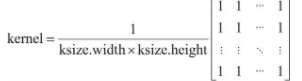

필터 마스크 행렬은 모든 원소 합이 1 또는 0이 되도록 설계한다. 1보다 작으면 입력 영상보다 어두운 영상이 생성되고 1보다 크면 밝은 형태의 결과 영상이 생성된다. 입력 영상의 평균 밝기를 유지하려면 1이 되어야 한다. 

필터 마스크 행렬 원소의 합이 0이면 전체적으로 검은색으로 구성된 필터링 영상이 생성된다.

In [5]:
import numpy as np
import cv2


def blurring_mean():
    src = cv2.imread('rose.bmp', cv2.IMREAD_GRAYSCALE)

    if src is None:
        print('Image load failed!')
        return

    cv2.imshow('src', src)

    for ksize in (3, 5, 7):
        dst = cv2.blur(src, (ksize, ksize))

        desc = "Mean: %dx%d" % (ksize, ksize)
        cv2.putText(dst, desc, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                   1.0, 255, 1, cv2.LINE_AA)

        cv2.imshow('dst', dst)
        cv2.waitKey()

    cv2.destroyAllWindows()
    
if __name__ == '__main__':
    blurring_mean()

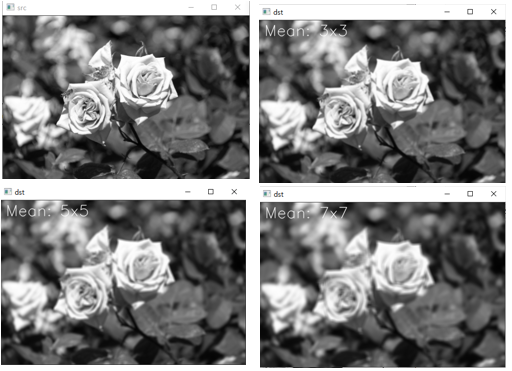

### 7.2.2 가우시안 필터

평균값 필터보다 자연스러운 블러링 결과를 생성하는 필터로 가우시안 분포 함수를 근사하여 생성한다.

가우시안 분포는 평균을 중심으로 좌우 대칭의 종 모양을 갖는 확률 분포를 말하며 정규 분포라고도 한다. 평균과 표준 편차에 따라 분포 모양이 결정된다. 영상의 가우시안 필터에서는 주로 평균이 0인 가우시안 분포 함수를 사용한다.

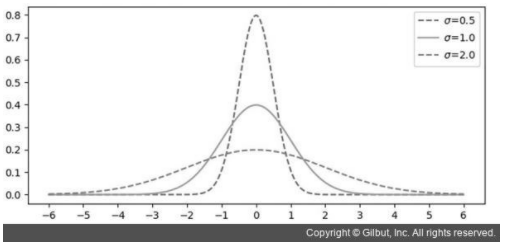

평균이 0인 1차원 가우시안 분포 함수 그래프

2차원 필터 마스크 행렬을 생성하려면 2차원 가우시안 분포 함수를 근사해야 한다.

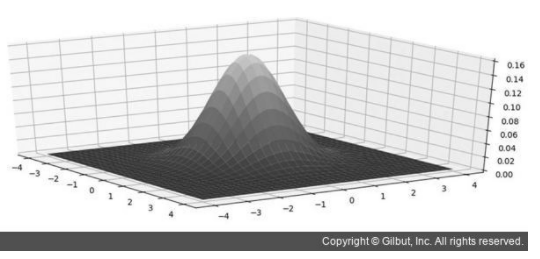

(0,0)에서 최대값을 갖고 멀어질수록 함수가 감소하는 그래프, 부피는 1이다.

가우시안 분포 함수는 연속 함수이지만 이산형의 마스크를 만들기 위해서 x와 y 값이 정수인 위치에서만 가우시안 분포 함수 값을 추출하여 마스크를 생성한다.

보통 필터 마스크의 크기는 (8*(표준편차) + 1)로 결정한다. 예를 들어서 표준 편차가 1이면

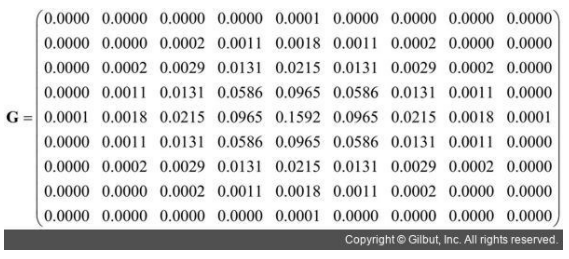

9x9 필터를 생성하게 된다. 하지만 예외적으로 CV_8U 깊이의 영상에 대해 가우시안 필터를 적용하면 (6*(표준편차)+1) 크기의 필터 마스크를 사용한다.

정수 좌표에서 가우시안 분포 함수 값을 선택하여 가우시안 필터 마스크를 만든 후, 필터 마스크 행렬 원소 합이 1이 되도록 행렬 원소 값의 크기를 전체적으로 조정해야 한다.

이 필터 마스크를 이용하여 마스크 연산을 수행한다는 것은 필터링 대상 픽셀 근처에는 가중치를 크게 주고, 필터링 대상 픽셀과 멀리 떨어져 있는 주변부에는 가중치를 조금만 주어서 가중 평균을 구하는 것이다. 즉, 가우시안 필터 마스크가 가중 평균을 구하기 위한 가중치 행렬 역할을 하는 것이다.

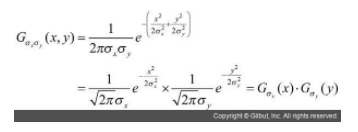

2차원 가우시안 분포 함수를 x축과 y축 방향의 1차원 가우시간 분포 함수의 곱으로 분리되서 연산 속도가 빨라진다.

**void GaussianBlur(InputArray src, OutputArray dst, Size ksize,
                  double sigmaX, double sigmaY = 0,
                  int borderType = BORDER_DEFAULT);**

|지정값|설명|
|:-----|:----------------------------------|
|src|입력 영상, 다채널 영상은 각 채널별로 블러링 수행|
|dst|출력 영상, src와 같은 크기, 같은 타입을 갖는다.|
|ksize|블러링 커널 크기,ksize에 Size()를 지정하면 표준 편차로부터 커널 크기를 자동으로 결정한다.|
|sigmaX|x 방향으로의 가우시안 커널 표준 편차|
|sigmaY|y 방향으로의 가우시안 커널 표준 편차|
|borderType|가장자리 픽셀 확장 방식|

큰 특별한 이유가 없다면 sigmaX,Y 나 SIZE()를 같은 걸로 맞추자!

In [8]:
def blurring_gaussian():
    src = cv2.imread('jh.bmp', cv2.IMREAD_GRAYSCALE)

    if src is None:
        print('Image load failed!')
        return

    cv2.imshow('src', src)

    for sigma in range(1, 6):
        dst = cv2.GaussianBlur(src, (0, 0), sigma)

        desc = "Gaussian: sigma = %d" % (sigma)
        cv2.putText(dst, desc, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                   1.0, 255, 1, cv2.LINE_AA)

        cv2.imshow('dst', dst)
        cv2.waitKey()

    cv2.destroyAllWindows()


if __name__ == '__main__':
    blurring_mean()
    blurring_gaussian()


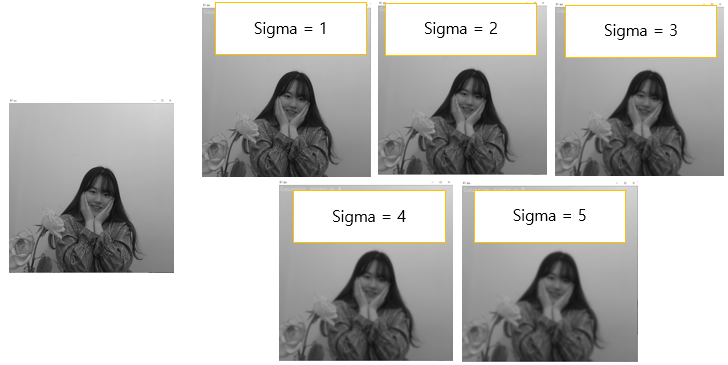

## 7.3 샤프닝 : 영상 날카롭게 하기

사물의 윤곽이 뚜렷하고 선명한 느낌이 나도록 영상을 변경하는 필터링 기법이다.

### 7.3.1. 언샤프 마스크 필터

샤프닝을 구현하기 위해서 블러링된 영상을 사용한다. 언샤프한 영상을 이용하여 역으로 날카로운 영상을 생성하는 필터를 언샤프 마스크 필터라고 한다.

In [9]:
import sys
import numpy as np
import cv2


src = cv2.imread('rose.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

cv2.imshow('src', src)

for sigma in range(1, 6):
    blurred = cv2.GaussianBlur(src, (0, 0), sigma)

    alpha = 1.0
    dst = cv2.addWeighted(src, 1 + alpha, blurred, -alpha, 0.0)

    desc = "sigma: %d" % sigma
    cv2.putText(dst, desc, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
               1.0, 255, 1, cv2.LINE_AA)

    cv2.imshow('dst', dst)
    cv2.waitKey()

cv2.destroyAllWindows()

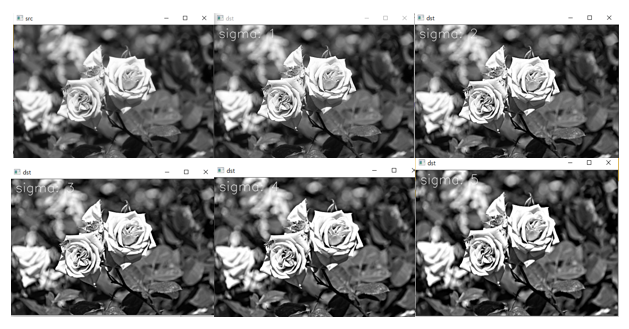

## 7.4. 잡음 제거 필터링

전처리 과정 중 하나인 잡음 제거 필터링.

### 7.4.1 영상과 잡음 모델

영상에서의 잡음은 주로 영상을 획득하는 과정에서 발생하며, 디지털 카메라에서 사진을 촬영하는 경우 광학적 신호를 전기적 신호로 변환하는 센서에서 주로 잡음이 추가된다.

$$
f(x,y) = s(x,y) + n(x,y), s(x,y) : 렌즈가 바라보는 장면(원본), n(x,y) : 잡음
$$

잡음이 생성되는 방식을 잡음 모델이라고 하며 대표적인 잡음 모델은 가우시안 잡음 모델이다.

**randn(InputOutputArray dst, InputArray mean, InputArray stddev);**

|지정값|설명|
|:-----|:----------------------------------|
|dst|가우시안 난수로 채워질 행렬, dst 행렬은 미리 할당 되어야 한다.|
|mean|가우시안 분포 평균|
|stddev|가우시안 분포 표준 편차|

In [12]:
import numpy as np
import cv2
import random


def noise_gaussian():
    src = cv2.imread('lenna.bmp', cv2.IMREAD_GRAYSCALE)

    if src is None:
        print('Image load failed!')
        return

    cv2.imshow('src', src)

    for stddev in [10, 20, 30]:
        noise = np.zeros(src.shape, np.int32) # 부호 있는 정수형을 사용
        cv2.randn(noise, 0, stddev)

        dst = cv2.add(src, noise, dtype=cv2.CV_8UC1) # 영상 깊이는 cv_8uc1

        desc = 'stddev = %d' % stddev
        cv2.putText(dst, desc, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                   1.0, 255, 1, cv2.LINE_AA)
        cv2.imshow('dst', dst)
        cv2.waitKey()

    cv2.destroyAllWindows()
    
if __name__ == '__main__':
    noise_gaussian()

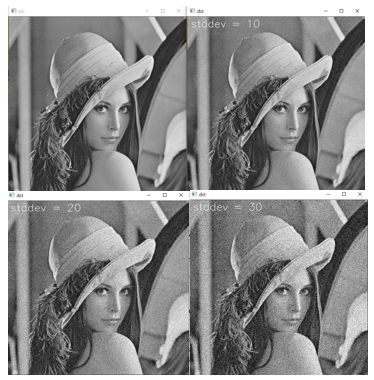

### 7.4.2 양방향 필터

가우시안 필터는 픽셀 값이 급격하게 변경되는 에지 금방에서는 잡음 뿐 아니라 에지 성분까지 함께 감소하는 효과가 보인다. 따라서 객체의 윤곽이 흐릿하게 바뀐다.

이런 단점을 보완하기 위해 보전 잡음 제거 필터에 대해 연구하다가 양방향 필터가 나오게 되었다.

양방향 필터는 에지 정보는 그대로 유지하면서 잡음만 제거하는 알고리즘이다.

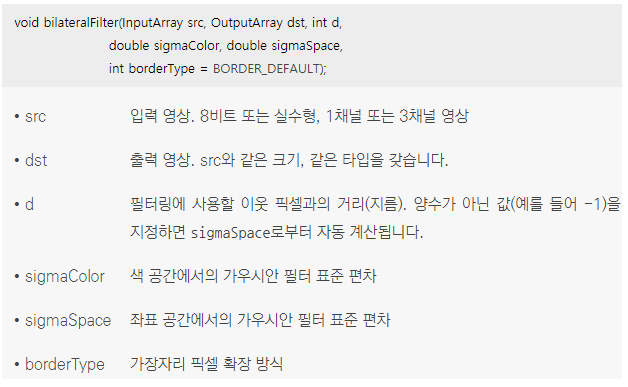

$$

g_p = 1/W_p*(sigma(G_( 이건 나중에 하자 ㅋㅋ)

In [13]:
def filter_bilateral():
    src = cv2.imread('lenna.bmp', cv2.IMREAD_GRAYSCALE)

    if src is None:
        print('Image load failed!')
        return

    noise = np.zeros(src.shape, np.int32)
    cv2.randn(noise, 0, 5)
    cv2.add(src, noise, src, dtype=cv2.CV_8UC1)

    dst1 = cv2.GaussianBlur(src, (0, 0), 5)
    dst2 = cv2.bilateralFilter(src, -1, 10, 5)
    
    cv2.imshow('src', src)
    cv2.imshow('dst1', dst1)
    cv2.imshow('dst2', dst2)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
if __name__ == '__main__':
    filter_bilateral()

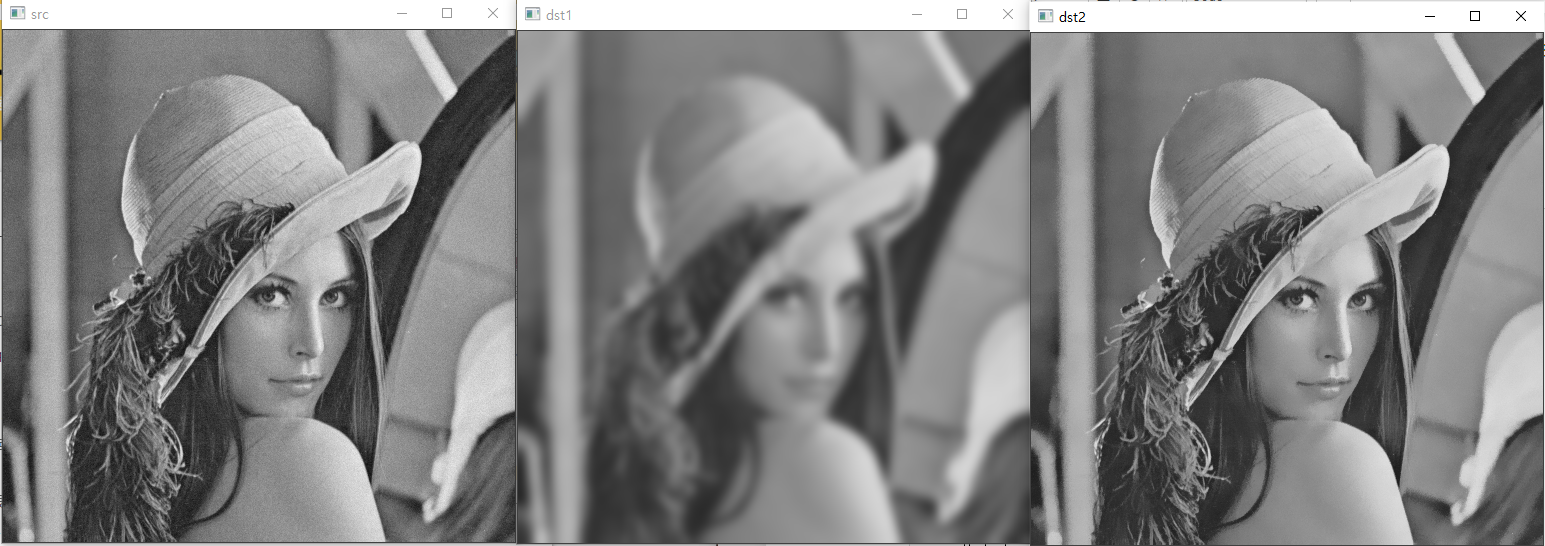

### 7.4.3 미디언 필터

입력 영상에서 자기 자신 픽셀 값 중에서 중간값을 선택하여 결과 영상 픽셀값으로 설정하는 필터링 기법이다.

주변 픽셀 값들의 중간값을 선택하기 위해 내부에서 픽셀 값 정렬 과정이 사용된다. 특히 잡음 픽셀 값이 주변 픽셀 값과 큰 차이가 있는 경우 효과적으로 동작한다.

영상에 추가되는 잡음 중 소금&후추 잡음은 픽셀 값이 일정 확률로 0 또는 255로 변경되는 형태의 잡음이다.

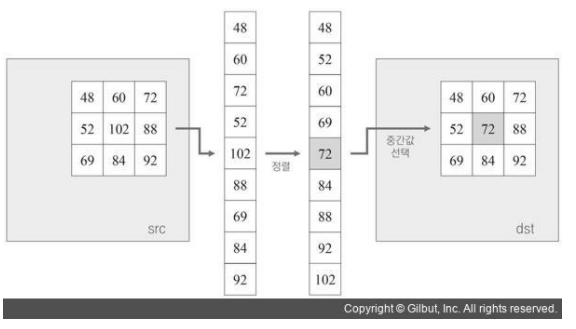

이와 같은 과정을 영상 전체 픽셀에 대하여 수행하면 미디언 필터 결과 영상이 만들어진다.

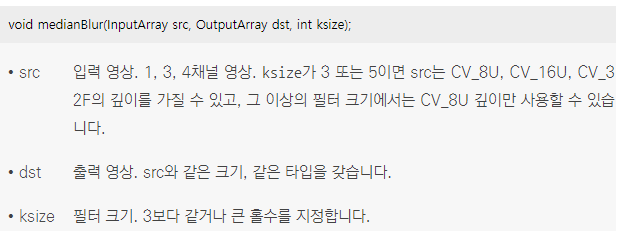

In [14]:
def filter_median():
    src = cv2.imread('lenna.bmp', cv2.IMREAD_GRAYSCALE)

    if src is None:
        print('Image load failed!')
        return
    
    # 소금,후추 잡음을 추가
    for i in range(0, int(src.size / 10)):
        x = random.randint(0, src.shape[1] - 1)
        y = random.randint(0, src.shape[0] - 1)
        src[x, y] = (i % 2) * 255
    
    # 가우시안과 미디안으로 비교해보기
    dst1 = cv2.GaussianBlur(src, (0, 0), 1)
    dst2 = cv2.medianBlur(src, 3)

    cv2.imshow('src', src)
    cv2.imshow('dst1', dst1)
    cv2.imshow('dst2', dst2)
    cv2.waitKey()
    cv2.destroyAllWindows()


if __name__ == '__main__':
    filter_median()

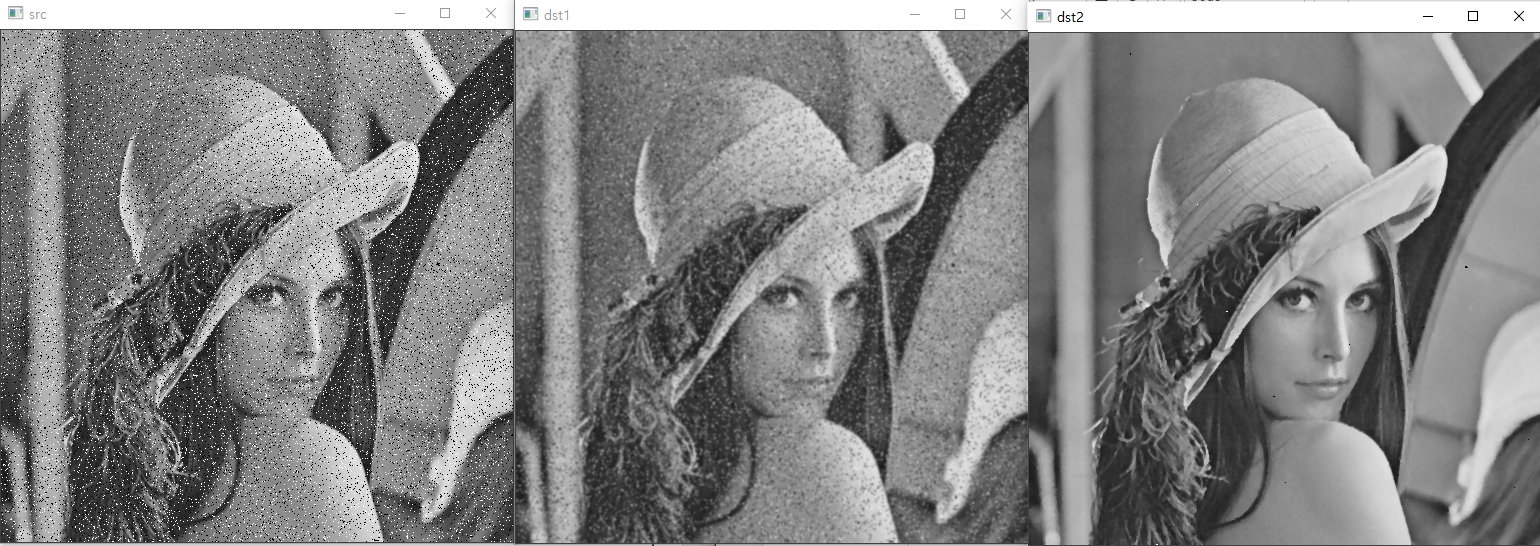